In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space,fp,seed ):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.input_layer = nn.Linear(observation_space, fp)
        self.output_layer = nn.Linear(fp, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

In [4]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):

    #Takes in state
    def __init__(self, observation_space, fs, seed):
        super(StateValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.input_layer = nn.Linear(observation_space, fs)
        self.output_layer = nn.Linear(fs, 1)

    def forward(self, x):
        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

In [5]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)

    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()

    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [6]:
def return_calc(rewards):
    ''' Converts our rewards history into cumulative discounted rewards
    Args:
    - rewards (Array): array of rewards

    Returns:
    - G (Array): array of cumulative discounted rewards
    '''
    #Calculate Gt (cumulative discounted rewards)
    G = []

    #track cumulative reward
    total_r = 0

    #iterate rewards from Gt to G0
    for r in reversed(rewards):

        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + total_r * DISCOUNT_FACTOR

        #add to front of G
        G.insert(0, total_r)

    #whitening rewards
    G = torch.tensor(G).to(DEVICE)
    G = (G - G.mean())/G.std()

    return G

In [7]:
def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): memory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''

    #store updates
    policy_loss = []

    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)

    #Backpropagation
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()


In [8]:
def val_update(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): memory of cumulative discounted rewards
    - state_vals (Array): memory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''

    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)

    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()

In [9]:


policylr = 0.001
valuelr = 0.001
fp = 128
fs = 128

env = gym.make('CartPole-v1')





seed_avg= []
seed_score=[]
for j in range(5):
  seed= np.random.randint(0,100)
  np.random.seed(seed)
  #Init network
  policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, fp, seed).to(DEVICE)
  stateval_network = StateValueNetwork(env.observation_space.shape[0], fs,seed).to(DEVICE)


  #Init optimizer
  policy_optimizer = optim.Adam(policy_network.parameters(), lr=policylr)
  stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=valuelr)


  #track scores
  scores = []
  avg_score= []
  avg_score_history= []
  score_history = []

  #recent 100 scores
  recent_scores = deque(maxlen=100)

  #iterate through episodes
  for episode in tqdm_notebook(range(NUM_EPISODES)):

    #reset environment, initiable variables
    state = env.reset()
    memory = []
    score = 0


      #generate episode
    for step in range(MAX_STEPS):
        #env.render()

        #select action
        action, lp = select_action(policy_network, state)

        #execute action
        new_state, reward, done, _ = env.step(action)

        #track episode score
        score += reward

        #store into memory
        memory.append([state, action, reward, lp])

        #end episode
        if done:
            break

        #move into new state
        state = new_state

    #append score
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_score_history.append(avg_score)

    #get items from memory
    states = [step[0] for step in memory]
    actions = [step[1] for step in memory]
    rewards = [step[2] for step in memory]
    lps = [step[3] for step in memory]

    #get discounted rewards
    G = return_calc(rewards)
    #G = torch.tensor(G).to(DEVICE)

    #calculate state values and train statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_vals.append(stateval_network(state))

    state_vals = torch.stack(state_vals).squeeze()

    val_rew = []
    for rew in rewards:
        rew = torch.tensor(rew)
        val_rew.append(rew)

    val_rew = torch.stack(val_rew).squeeze()

    val_update(val_rew, state_vals, stateval_optimizer)


    #calculate deltas and train policy network
    # if update== 'type2':
    deltas = [gt - val for gt, val in zip(G, state_vals)]
    deltas = torch.tensor(deltas).to(DEVICE)

    train_policy(deltas, lps, policy_optimizer)

  seed_avg.append(np.array(avg_score_history))
  seed_score.append(np.array(scores))
  env.close()

mean_seed_avg= np.mean(seed_avg, axis=0)
mean_seed_score= np.mean(seed_score, axis=0)




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-9-30b23bc0cc89>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
seed_avg3= []
seed_score3=[]
for j in range(5):
  seed= np.random.randint(0,100)
  np.random.seed(seed)
  #Init network
  policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, fp, seed).to(DEVICE)
  stateval_network = StateValueNetwork(env.observation_space.shape[0], fs,seed).to(DEVICE)


  #Init optimizer
  policy_optimizer = optim.Adam(policy_network.parameters(), lr=policylr)
  stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=valuelr)


  #track scores
  scores = []
  avg_score= []
  avg_score_history= []
  score_history = []

  #recent 100 scores
  recent_scores = deque(maxlen=100)

  #iterate through episodes
  for episode in tqdm_notebook(range(NUM_EPISODES)):

    #reset environment, initiable variables
    state = env.reset()
    memory = []
    score = 0


      #generate episode
    for step in range(MAX_STEPS):
        #env.render()

        #select action
        action, lp = select_action(policy_network, state)

        #execute action
        new_state, reward, done, _ = env.step(action)

        score += reward

        #store into memory
        memory.append([state, action, reward, lp])

        #end episode
        if done:
            break

        #move into new state
        state = new_state

    #append score
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_score_history.append(avg_score)

    #get items from memory
    states = [step[0] for step in memory]
    actions = [step[1] for step in memory]
    rewards = [step[2] for step in memory]
    lps = [step[3] for step in memory]

    #get discounted rewards
    G = return_calc(rewards)
    #G = torch.tensor(G).to(DEVICE)

    #calculate state values and train statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_vals.append(stateval_network(state))

    state_vals = torch.stack(state_vals).squeeze()

    val_rew = []
    for rew in rewards:
        rew = torch.tensor(rew)
        val_rew.append(rew)

    val_rew = torch.stack(val_rew).squeeze()

    val_update(G, state_vals, stateval_optimizer)


    #calculate deltas and train policy network
    # if update== 'type2':
    deltas = [gt - val for gt, val in zip(G, state_vals)]
    deltas = torch.tensor(deltas).to(DEVICE)

    train_policy(deltas, lps, policy_optimizer)


  seed_avg3.append(np.array(avg_score_history))
  seed_score3.append(np.array(scores))
  env.close()

mean_seed_avg3= np.mean(seed_avg3, axis=0)
mean_seed_score3= np.mean(seed_score3, axis=0)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-13-8761ede23284>:37: TqdmDep

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
env = gym.make('CartPole-v1')

seed_avg1= []
seed_score1=[]
for j in range(5):
  seed= np.random.randint(0,100)
  np.random.seed(seed)
  policy_network1 = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, fp, seed).to(DEVICE)
  policy_optimizer = optim.Adam(policy_network1.parameters(), lr=policylr)
  #track scores
  scores = []
  avg_score= []
  avg_score_history= []
  score_history = []

  #recent 100 scores
  recent_scores = deque(maxlen=100)

  #iterate through episodes
  for episode in tqdm_notebook(range(NUM_EPISODES)):

    #reset environment, initiable variables
    state = env.reset()
    memory = []
    score = 0


      #generate episode
    for step in range(MAX_STEPS):
        #env.render()

        #select action
        action, lp = select_action(policy_network1, state)

        #execute action
        new_state, reward, done, _ = env.step(action)

        #track episode score
        score += reward

        #store into memory
        memory.append([state, action, reward, lp])

        #end episode
        if done:
            break

        #move into new state
        state = new_state

    #append score
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_score_history.append(avg_score)

    #get items from memory
    states = [step[0] for step in memory]
    actions = [step[1] for step in memory]
    rewards = [step[2] for step in memory]
    lps = [step[3] for step in memory]

    #get discounted rewards
    G = return_calc(rewards)
    #G = torch.tensor(G).to(DEVICE)

    deltas = [gt for gt in zip(G)]
    deltas = torch.tensor(deltas).to(DEVICE)

    train_policy(deltas, lps, policy_optimizer)
  seed_avg1.append(np.array(avg_score_history))
  seed_score1.append(np.array(scores))
  env.close()

mean_seed_avg1= np.mean(seed_avg1, axis=0)
mean_seed_score1= np.mean(seed_score1, axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-10-d305a802b7e5>:26: TqdmDep

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

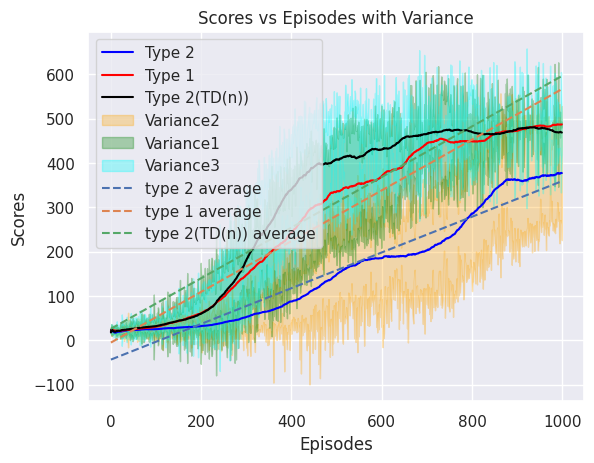

In [19]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

variance_scores2 = np.var(seed_score, axis=0)
variance_scores1 = np.var(seed_score1, axis=0)
variance_scores3 = np.var(seed_score3, axis=0)

# Plot the mean scores
plt.plot(mean_seed_avg, label='Type 2', color='blue')
plt.plot(mean_seed_avg1, label='Type 1', color='red')
plt.plot(mean_seed_avg3, label='Type 2(TD(n))', color='black')

# Fill in the variance
plt.fill_between(range(len(mean_seed_avg)), mean_seed_avg - np.sqrt(variance_scores2),
                 mean_seed_avg + np.sqrt(variance_scores2), alpha=0.3, color='orange', label='Variance2')

plt.fill_between(range(len(mean_seed_avg1)), mean_seed_avg1 - np.sqrt(variance_scores1),
                 mean_seed_avg1 + np.sqrt(variance_scores1), alpha=0.3, color='green', label='Variance1')

plt.fill_between(range(len(mean_seed_avg3)), mean_seed_avg3 - np.sqrt(variance_scores3),
                 mean_seed_avg3 + np.sqrt(variance_scores3), alpha=0.3, color='cyan', label='Variance3')





reg1 = LinearRegression().fit(np.arange(len(mean_seed_avg)).reshape(-1, 1), np.array(mean_seed_avg).reshape(-1, 1))
y_pred1 = reg1.predict(np.arange(len(mean_seed_avg)).reshape(-1, 1))
plt.plot(y_pred1, linestyle='--', label= 'type 2 average')

reg2 = LinearRegression().fit(np.arange(len(mean_seed_avg1)).reshape(-1, 1), np.array(mean_seed_avg1).reshape(-1, 1))
y_pred2 = reg2.predict(np.arange(len(mean_seed_avg1)).reshape(-1, 1))
plt.plot(y_pred2, linestyle='--', label='type 1 average')

reg3 = LinearRegression().fit(np.arange(len(mean_seed_avg3)).reshape(-1, 1), np.array(mean_seed_avg3).reshape(-1, 1))
y_pred2 = reg3.predict(np.arange(len(mean_seed_avg3)).reshape(-1, 1))
plt.plot(y_pred2, linestyle='--', label='type 2(TD(n)) average')

# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.title('Scores vs Episodes with Variance')
plt.legend()

# Show plot
plt.show()


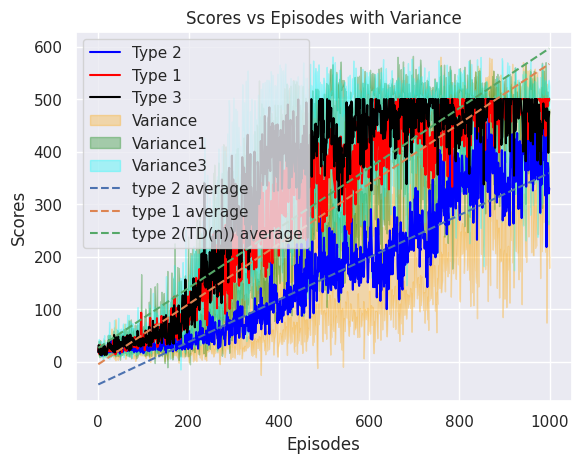

In [18]:

sns.set()

variance_scores2 = np.var(seed_score, axis=0)
variance_scores1 = np.var(seed_score1, axis=0)
variance_scores3 = np.var(seed_score3, axis=0)

# Plot the mean scores
plt.plot(mean_seed_score, label='Type 2', color='blue')
plt.plot(mean_seed_score1, label='Type 1', color='red')
plt.plot(mean_seed_score3, label='Type 3', color='black')

# Fill in the variance
plt.fill_between(range(len(mean_seed_score)), mean_seed_score - np.sqrt(variance_scores2),
                 mean_seed_score + np.sqrt(variance_scores2), alpha=0.3, color='orange', label='Variance')

plt.fill_between(range(len(mean_seed_score1)), mean_seed_score1 - np.sqrt(variance_scores1),
                 mean_seed_score1 + np.sqrt(variance_scores1), alpha=0.3, color='green', label='Variance1')

plt.fill_between(range(len(mean_seed_score3)), mean_seed_score3 - np.sqrt(variance_scores3),
                 mean_seed_score3 + np.sqrt(variance_scores3), alpha=0.3, color='cyan', label='Variance3')




reg1 = LinearRegression().fit(np.arange(len(mean_seed_avg)).reshape(-1, 1), np.array(mean_seed_avg).reshape(-1, 1))
y_pred1 = reg1.predict(np.arange(len(mean_seed_avg)).reshape(-1, 1))
plt.plot(y_pred1, linestyle='--', label= 'type 2 average')

reg2 = LinearRegression().fit(np.arange(len(mean_seed_avg1)).reshape(-1, 1), np.array(mean_seed_avg1).reshape(-1, 1))
y_pred2 = reg2.predict(np.arange(len(mean_seed_avg1)).reshape(-1, 1))
plt.plot(y_pred2, linestyle='--', label='type 1 average')

reg3 = LinearRegression().fit(np.arange(len(mean_seed_avg3)).reshape(-1, 1), np.array(mean_seed_avg3).reshape(-1, 1))
y_pred2 = reg3.predict(np.arange(len(mean_seed_avg3)).reshape(-1, 1))
plt.plot(y_pred2, linestyle='--', label='type 2(TD(n)) average')

# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.title('Scores vs Episodes with Variance')
plt.legend()

# Show plot
plt.show()
